**Imports**

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec, lines, legend_handler, image
from matplotlib.patches import Patch, Rectangle, FancyBboxPatch, BoxStyle, Circle
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import seaborn as sns

import numpy as np
import pandas as pd
import scipy.stats as scs
from statsmodels.formula.api import ols
from os import path
from io import StringIO
from IPython.display import display
from tqdm.notebook import tqdm
from PIL import Image
import inspect

from python_scripts.utils import loc_utils as lut
from python_scripts.utils import vis_utils as vut
from python_scripts.utils.vis_utils import gcolors, glabels, fullglabels, gmarkers, colors, ncolors, tlabels
from python_scripts.utils.model_utils import get_baseline_aic, softmax_1d

from python_scripts.utils.model_utils import SoftmaxChoiceModel, neg_log_likelihood, normalize, get_baseline_aic

plt.style.use('python_scripts/my.mplstyle')
get_fname = lambda: inspect.stack()[1][3]

# Define size variables according to Nature guidelines
cm2in = lambda x: x*0.393701
oneC = 8.6
twoC = 17.8

def single(height_in_cm):
    return cm2in(oneC), cm2in(height_in_cm)

def double(height_in_cm):
    print(f'Figure size {twoC}cm wide x {height_in_cm}cm tall')
    return cm2in(twoC), cm2in(height_in_cm)

lf = 9

# Figures from main article

## Figure 1

### Resize images

In [13]:
def make_thumbnail(input_image_path, output_image_path, width=None, height=None):
    original_image = Image.open(input_image_path)
    w, h = original_image.size
    if width and height:
        size = (width, height)
    elif width:
        size = (width, h)
    elif height:
        size = (w, height)
    else:
        # No width or height specified
        raise RuntimeError('Width or height required!')

    original_image.thumbnail(size, Image.ANTIALIAS)
    background = Image.new('RGBA', size, 'WHITE')
    background.paste(
        original_image, (int((size[0] - original_image.size[0]) / 2), int((size[1] - original_image.size[1]) / 2))
    )
    
    background.save(output_image_path)

foods_and_categories = {
    'Bear': ('apple', 'bacon'),
    'Bunny': ('bananas', 'broccoli'),
    'GreenMonster': ('carrot', 'cheese'),
    'Squid': ('cherry', 'fried_eggs')
}

for ci, (c, fs)  in enumerate(foods_and_categories.items(), 1):
    input_image_path = f'stimuli/monsters-preview/{c}.png'
    output_image_path = f'images/c{ci}_thumb.png'
    print(f'Resizing {input_image_path}')
    make_thumbnail(input_image_path, output_image_path, width=100, height=100)
    for fi, f in enumerate(fs, 1):
        input_image_path = f'stimuli/food/{f}.png'
        output_image_path = f'images/f{ci}{fi}_thumb.png'
        print(f'Resizing {input_image_path}')
        make_thumbnail(input_image_path, output_image_path, width=100, height=100)

    
for ci, c in enumerate(foods_and_categories.keys(), 1):
    n = 1
    for i in range(1, 7):
        for j in range(1, 7):
            input_image_path = f'stimuli/monsters/{c}_{i}_{j}.png'
            output_image_path = f'images/s{ci}_{n}_thumb.png'
            print(f'Resizing {input_image_path}')
            make_thumbnail(input_image_path, output_image_path, width=200, height=200)
            n += 1

    
for f, fc in [('greencheck', 'fpos'), ('redx', 'fneg')]:
    input_image_path = f'stimuli/feedback/{f}.png'
    output_image_path = f'images/{fc}_thumb.png'
    print(f'Resizing {input_image_path}')
    make_thumbnail(input_image_path, output_image_path, width=100, height=100)

Resizing stimuli/feedback/greencheck.png
Resizing stimuli/feedback/redx.png


### Make plot

Figure size 17.8cm wide x 6.5cm tall


<IPython.core.display.Javascript object>


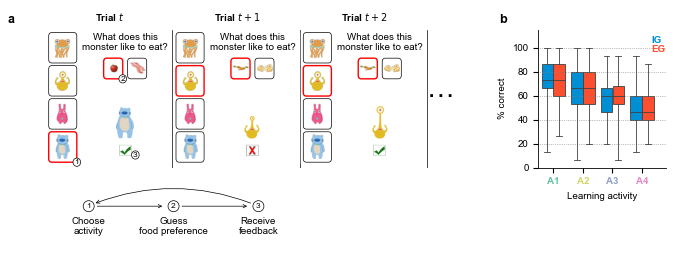

SAVED TO: figures/figure1.pdf


In [19]:
def add_image(ax, path, img_zoom, xy_img, xy_frame, side, show_frame=True, select=False, tag=None):
    # Read image and put it into annotation box
    img_arr = image.imread(path)
    img_box = OffsetImage(img_arr, zoom = img_zoom, resample=True)
    ann_box = AnnotationBbox(img_box, xy=xy_img, bboxprops=dict(edgecolor='w'))
    ax.add_artist(ann_box)
    
    # Draw a fancy-box frame around image
    if show_frame:
        frame = FancyBboxPatch(
            xy = xy_frame, 
            height = side, 
            width = side,
            boxstyle = BoxStyle('Round', pad=0, rounding_size=0.025),
            facecolor = (.0, .0, .0, .0),
            edgecolor = 'r' if select else 'k',
            linewidth = 1 if select else .5,
            zorder = 99
        )
        ax.add_patch(frame)
    
    if tag is not None:
        x = xy_frame[0]+side
        y = xy_frame[1]
        circle_tag = Circle((x, y), .03, fc='w', ec='k', lw=.5, zorder=999)
        ax.add_patch(circle_tag)
        ax.text(x, y, tag, ha='center', va='center', fontsize=6, zorder=9999)
    
    
def draw_example_panel(ax, choice=1, guess=1, stimulus=1, feedback=None, tags=True):
    pad = .02
    H = 1 - pad*2
    # Draw side menu
    s = .25*H # side button size
    m = .02*H # side button margin
    for i, c in enumerate('1234'):
        tag = '1' if (tags and c==str(choice)) else None
        add_image(
            ax = ax,
            path = f'images/c{c}_thumb.png',
            img_zoom = .18,
            xy_img = (s/2 + m/2, s*i + s/2 + m/2 + pad),
            xy_frame = (0 + m, s*i + m + pad),
            side = s-m,
            select = c==str(choice),
            tag = tag
        )
    
    # Draw main panel
    xcenter = s + (1 - s)/2
    
    # Text annotations
    prompt = 'What does this\nmonster like to eat?'
    ax.text(xcenter, .98, prompt, ha='center', va='top', fontsize=7)
    
    # Food categories
    ss = .15
    h = .5 + .25/2
    for i, g in enumerate('12'):
        xoffset = m if i else -ss-m
        tag = '2' if (tags and g==str(guess)) else None
        add_image(
            ax = ax,
            path = f'images/f{choice}{g}_thumb.png',
            img_zoom = 0.11,
            xy_img = (xcenter + xoffset + ss/2, h + ss/2 + m),
            xy_frame = (xcenter + xoffset, h + m),
            side = ss,
            select = g==str(guess),
            tag = tag
        )
        
    # Stimulus
    h = .45
    add_image(
        ax = ax,
        path = f'images/s{choice}_{stimulus}_thumb.png',
        img_zoom = 0.18,
        xy_img = (xcenter, s + s/2 + m),
        xy_frame = (xcenter, h + m),
        side = h/2,
        show_frame = False
    )
    
    # Feedback
    h = .13
    if feedback is not None:
        p = 'pos' if feedback else 'neg'
        tag = '3' if tags else None
        add_image(
            ax = ax,
            path = f'images/f{p}_thumb.png',
            img_zoom = 0.12,
            xy_img = (xcenter, s/2),
            xy_frame = (xcenter + s/3, h - 2 * m),
            side = 0,
            show_frame = False,
            tag = tag
        )
        

def subfig_1a(ax):
    vut.strip_axes(ax, remove_spines=False)
    w = .90 / 3
    
    # First example trial
    axin = vut.strip_axes(ax.inset_axes([w*0, 0, w, 1]), remove_spines=True)
    axin.axvline(.99, color='k', lw=.5)
    axin.set_title(r'Trial $t$', fontsize=7)
    draw_example_panel(axin, stimulus=15, choice=1, tags=True, feedback=1)
    
    # Second example trial
    axin = vut.strip_axes(ax.inset_axes([w*1, 0, w, 1]), remove_spines=True)
    axin.axvline(.99, color='k', lw=.5)
    axin.set_title(r'Trial $t + 1$', fontsize=7)
    draw_example_panel(axin, stimulus=2, choice=3, tags=False, feedback=0)
    
    # Third example trial
    axin = vut.strip_axes(ax.inset_axes([w*2, 0, w, 1]), remove_spines=True)
    axin.axvline(.99, color='k', lw=.5)
    axin.set_title(r'Trial $t + 2$', fontsize=7)
    draw_example_panel(axin, stimulus=16, choice=3, tags=False, feedback=1)
    
    # Dots
    ax.text(1.0, 0.5, '···  ', fontsize=20, ha='right', va='center')


def subfig_1a_legend(ax):
    r = 0.2
    h = 0.5
    a = 'center'
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 1)
    
    box = dict(boxstyle='circle', fc='w', lw=.5)
    arrow = dict(arrowstyle='->', lw=.5)
    ax.annotate('1', xy=(3-r, h), xytext=(1, 0.5), va=a, ha=a, fontsize=6, bbox=box, arrowprops=arrow)
    ax.annotate('2', xy=(5-r, h), xytext=(3, 0.5), va=a, ha=a, fontsize=6, bbox=box, arrowprops=arrow)
    arrow['connectionstyle'] = 'arc3,rad=0.2'
    ax.annotate('3', xy=(1+.1, h+.05), xytext=(5, 0.5), va=a, ha=a, fontsize=6, bbox=box, arrowprops=arrow)
    
    t = 'Choose\nactivity'
    ax.text(1, h/2, t, va='top', ha=a)
    
    t = 'Guess\nfood preference'
    ax.text(3, h/2, t, va='top', ha=a)

    t = 'Receive\nfeedback'
    ax.text(5, h/2, t, va='top', ha=a)

    
def subfig_1b(ax, data_path):
    # Load data
    columns = ['sid','group','trial','rpc1','rpc2','rpc3','rpc4']
    df = pd.read_csv(data_path).filter(items=columns)
    # Select PC values for last trial of familiarization
    df = df.loc[df.trial.eq(60), :].drop(columns='trial')
    # Convert to long format
    df = pd.wide_to_long(df, stubnames='rpc', i=['sid','group'], j='activity').reset_index()
    df.sort_values(by=['group','sid'], inplace=True)
#     display(df.head())
    # Convert to percentages
    df['percent_correct'] = df.rpc * 100
    # Plot
    sns.boxplot(x='activity', y='percent_correct', hue='group', data=df, whis=[0, 100], linewidth=.6,
                saturation=1, palette=sns.set_palette(sns.color_palette(gcolors)), ax=ax)
    props = {'connectionstyle': 'bar',
             'arrowstyle': '-',
             'patchA': None, 'patchB': None,
             'shrinkA': 5, 'shrinkB': 5,
             'linewidth': 0.6}

    ax.set_ylim(0, 115)
    ax.set_xlim(-.5, 3.8)
    ax.set_xlabel('Learning activity')
    ax.set_ylabel('% correct')
    ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontweight='bold')
    for xt, c in zip(ax.get_xticklabels(), colors):
        xt.set_color(c)
    # Add legend
    ax.legend_.remove()
    ax.text(3.3, 110, glabels[0], va='top', ha='left',
            fontsize=7, fontweight='bold', color=gcolors[0])
    ax.text(3.3, 95, glabels[1], va='bottom', ha='left',
            fontsize=7, fontweight='bold', color=gcolors[1])


def make_fig1(figname, save_to, save_as=''):
    fig = plt.figure(figname, figsize=double(6.5), facecolor='white')
    gs = fig.add_gridspec(ncols=4, nrows=2, width_ratios=[.1,4,.1,1.2], height_ratios=[1,.3])
    
    # Subplot (a)
    vut.add_subplot_label(x=0, y=1.05, label='a', size=lf, ax=fig.add_subplot(gs[0, 0]))
    ax_a = fig.add_subplot(gs[0, 1])
    vut.ghost(ax_a)
    subfig_1a(ax_a)
    # Add legend to subplot (a)
    ax_a_legend = vut.ghost(fig.add_subplot(gs[1, 1]))
    subfig_1a_legend(ax_a_legend)
    
    # Subplot (b)
    vut.add_subplot_label(x=0, y=1.05, label='b', size=lf, ax=fig.add_subplot(gs[0, 2]))
    ax_b = vut.pretty(fig.add_subplot(gs[0, 3]), 'y')
    subfig_1b(ax_b, 'data/heuristics_data.csv')

    # Save figure
    fig.subplots_adjust(left=.01, right=.95)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=150)
        
        
make_fig1(
    figname = 'figure1',
    save_to = 'figures',
    save_as = 'pdf' # File format (png, jpeg, svg, ...)
)

## Figure 2

In [ ]:
def fig_2a(axes, data_path, ghost_axis):
    # Load data, select columns
    df = pd.read_csv(data_path)[['sid','group','trial','activity']]
    # Select free-play trials
    df = df.loc[df.trial.le(60+250) & df.trial.gt(60), :]
    df.loc[:, 'trial'] -= 60
    # Get group sizes
    group_sizes = [group_sids.size for group_sids in df.groupby(['group']).sid.unique().values]
    # Count subjects per activity per trial for each group
    df = df.groupby(['group','activity','trial']).agg({'sid': 'nunique'})
    df = df.rename(columns={'sid':'n'})
    # Create ghost axis for common label
    vut.ghost(ghost_axis)
    ghost_axis.set_ylabel('Fraction of Ps selecting a learning activity', labelpad=20)
    # Plot data
    for i, grp in enumerate([1, 0]):
        ax = axes[i]
        ax.set_xlim(1, 250)
        ax.set_ylim(.08, .5)
        ax.grid(True)
        if i == 1:
            ax.set_xlabel('Trial')
        else:
            ax.tick_params(labelbottom=False)
            handles = [lines.Line2D([0], [0], color=colors[k], markersize=5, ls='', marker='o', label=tlabels[k + 1]) for k in range(4)]
            leg = ax.legend(handles, tlabels.values(), handletextpad=.01, fontsize=6,
                            bbox_to_anchor=(-.1, 1, 1.2, 0.2), loc='lower left', mode='expand', ncol=4)
            vut.color_legend(leg)
        txt = ax.text(x=.05, y=.95, s=fullglabels[grp],
                      ha='left', va='top', transform=ax.transAxes,
                      color=gcolors[grp], fontweight='bold', fontsize=7)

        for j, activity in enumerate(df.index.unique(1).tolist()):
            psel = df.loc[(grp, activity, slice(None)), 'n'].sort_index().values / group_sizes[grp]
            ax.plot(psel, c=colors[j], label=activity, lw=1)


def fig_2b(ax, data_path):
    # Load data
    df = pd.read_csv(data_path)
    df = df.replace({'group': {0: 'IG', 1: 'EG'}})
    df = df.loc[df.nam.gt(0), :]
    # Plot data
    sns.histplot(
        df, x='dwfpc', hue='group', element='step',
        stat='probability', common_norm=True, bins=15, ax=ax,
        palette=sns.set_palette(sns.color_palette(gcolors)), legend=True,
        linewidth=1
    )
    ax.set_ylabel('Frequency')
    ax.set_xlabel('dwfPC')
    # Add legend
    legend = ax.get_legend()
    legend.set_title('')
    legend.set_bbox_to_anchor([.25, .65, .2, .3])


def fig_2(figname, save_to, save_as=''):
    fig = plt.figure(figname, figsize=single(12), facecolor='white')
    gs = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[2, 1], width_ratios=[.1, 1])
    gs_a = gs[0, 1].subgridspec(2, 1)

    # Subplot (a)
    vut.add_subplot_label(x=-.8, y=1.1, label='a', size=lf, ax=fig.add_subplot(gs[0, 0]))
    ghost_axis = fig.add_subplot(gs_a[0:2, 0], facecolor=(1, 1, 1, 0))
    axes = [vut.pretty(fig.add_subplot(gs_a[i, 0])) for i in range(2)]
    fig_2a(axes, 'data/clean_data.csv', ghost_axis)
   
    # Subplot (b)
    vut.add_subplot_label(x=-.8, y=1.1, label='b', size=lf, ax=fig.add_subplot(gs[1, 0]))
    ax_b = vut.pretty(fig.add_subplot(gs[1, 1]), 'y')
    fig_2b(ax_b, 'data/learning_data.csv')

    # Save figure
    fig.subplots_adjust(left=.10, right=.85, top=.90, bottom=.10, hspace=.30, wspace=.1)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)
        
        
fig_2(
    figname = 'figure2',
    save_to = 'figures',
    save_as = 'pdf' # File format (png, jpeg, svg, ...)
)

## Figure 3

See related analyses in /R_scripts/dwfpc_by_grp-NAM.R

In [ ]:
def fig_3a(ax, data_path):
    df = pd.read_csv(data_path)
    df = df.loc[df.nam > 0, :]
    bins = np.arange(0., 1.02, 0.1)
    nam_labels = ['NAM ' + str(i) for i in (1, 2, 3)]

    for nam in [1, 2, 3]:
        for group in [0, 1]:
            y = df.loc[df.nam.eq(nam) & df.group.eq(group), 'dwfpc']
            rf, _ = np.histogram(y, bins=bins, weights=np.ones_like(y) / y.size)
            ax.plot(
                bins[1:], rf, c=ncolors[nam - 1], 
                lw=.6, markersize=2,
                ls = '-' if group else '--', marker='o',
            )
    ax.set_xlim(0.40, 1.02)
    # Edit legend
    c = 'darkgray'
    legmark = lambda x: lines.Line2D([0], [0], ls='', marker='o', markerfacecolor=ncolors[x], markeredgecolor=ncolors[x], markersize=2)
    legline = lambda x: lines.Line2D([0], [0], color=c, lw=.6, ls=['-','--'][x], label=fullglabels[x])
    nam_leg = [legmark(n) for n in [0, 1, 2]]
    grp_leg = [legline(g) for g in [0, 1]]
    leg_labs = nam_labels + list(fullglabels.values())
    ax.legend(
        nam_leg + grp_leg, leg_labs,
        bbox_to_anchor=(.5, .80,),
        loc='lower center', ncol=2
        ,
        fontsize=6,
        handler_map={tuple: legend_handler.HandlerTuple(ndivide=None)}
    )
    ax.set_ylim(0, .6)
    ax.set_xlabel('Weighted performance (dwfPC)')
    ax.set_ylabel('Frequeny')


def fig_3b(ax, data_path):
    # Load data
    df = pd.read_csv(data_path)
    df = df.loc[df.nam > 0, :]
    # Get counts and relative frequencies within groups
    df = df.groupby(['group','nam'])[['sid']].agg('count').rename(columns={'sid':'count'}).reset_index()
    df['group_count'] = df.groupby('group').transform('sum').loc[:, 'count']
    print(df)
    df['rf'] = df.loc[:, 'count'] / df.loc[:, 'group_count'] * 100
    df = df.replace({'group':{0: 'IG', 1: 'EG'}})
    # Plot
    sns.barplot(
        x='nam', y='rf', hue='group', data=df, ax=ax, saturation=1,
        palette=sns.set_palette(sns.color_palette(gcolors))
    )
    ax.set_ylabel('% of participants')
    ax.set_xlabel(None)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['\nNAM {}'.format(nam) for nam in [1, 2, 3]])
    ax.tick_params(axis='x', pad=-5)
    # Legend
    ax.get_legend().remove()
    ax.text(1-.2, 41, 'IG', fontweight='bold', fontsize=9, color=gcolors[0], ha='center')
    ax.text(1+.2, 32, 'EG', fontweight='bold', fontsize=9, color=gcolors[1], ha='center')
    vut.change_width(ax, .3)


def fig_3c(axes, data_path, nam_data_path):
    # Load data
    df = pd.read_csv(data_path).filter(items=['sid','group','trial','activity'])
    # Select only required free-play trials (N = 250)
    df = df.loc[df.trial.le(60+250) & df.trial.gt(60), :]
    nam_df = pd.read_csv(nam_data_path).filter(items=['sid','nam','mp3']).set_index('sid')
    df = df.dropna().drop(columns='trial')
    df = df.merge(nam_df.drop(columns='mp3'), on='sid')
    df = df.loc[df.nam.gt(0), :]
    # Count trials per activity for each subject
    counts = df.groupby(['group', 'nam', 'sid']).activity.value_counts().to_frame('counts')
    counts = 100*counts / counts.groupby(['group', 'nam', 'sid']).transform('sum')
    counts_stats = counts.groupby(['group','nam','activity']).agg(['mean', 'sem'])
    counts_stats.columns = counts_stats.columns.droplevel(0)

    # Plot
    for nam in [1, 2, 3]:
        ax = axes[nam-1]
        ax.set_title(f'NAM {nam}', fontsize=7, fontweight='normal')
        ax.axhline(25, ls='--', color='k', alpha=.8, lw=.6)
        x = np.array([1, 2, 3, 4])
        for i, group in enumerate([0, 1]):
            x_ = x+[-.1, .1][group]
            y = counts_stats.loc[(group, nam, slice(None)), 'mean']
            yerr = counts_stats.loc[(group, nam, slice(None)), 'sem']
            ax.errorbar(x_, y, yerr=yerr, color=gcolors[group], marker=gmarkers[group],
                        capsize=0, markersize=2, lw=.6)
#         ax.set_ylim(10, 75)
        ax.set_xticks(x)
        ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontweight='bold')
        for xt, c in zip(ax.get_xticklabels(), colors):
            xt.set_color(c)
        if nam == 1:
            ax.set_ylabel('Time allocation\n(%; Mean and SEM)')
        if nam == 2:
            ax.set_xlabel('Learning activity'.format(nam))
        if nam == 2:
            ax.text(3.1, 34, 'EG', ha='center', va='center', color=gcolors[1], fontsize=8, fontweight='bold')
            ax.text(3.5, 16, 'IG', ha='center', va='center', color=gcolors[0], fontsize=8, fontweight='bold')


def fig_3(figname, save_to, save_as=''):
    fig = plt.figure(figname, figsize=single(9), facecolor='white')
    gs = fig.add_gridspec(
        ncols=2, nrows=3,
        width_ratios=[.1, 1],
        height_ratios=[1, 1, .8]
    )
    labx, laby = .5, 1.1
    # Subplot (a)
    vut.add_subplot_label(x=labx, y=laby, label='a', size=lf, ax=fig.add_subplot(gs[0, 0]))
    ax = vut.pretty(fig.add_subplot(gs[0, 1]))
    fig_3a(ax, 'data/learning_data.csv')
    # Subplot (b)
    vut.add_subplot_label(x=labx, y=laby, label='b', size=lf, ax=fig.add_subplot(gs[1, 0]))
    ax = vut.pretty(fig.add_subplot(gs[1, 1]))
    fig_3b(ax, 'data/learning_data.csv')
    # Subplot (c)
    vut.add_subplot_label(x=labx, y=laby, label='c', size=lf, ax=fig.add_subplot(gs[2, 0]))
    gs_c = gs[2, 1].subgridspec(1, 3)                      
    axes = [vut.pretty(fig.add_subplot(gs_c[0, i]), 'y') for i in range(3)]
    fig_3c(axes, 'data/clean_data.csv', 'data/nam_data.csv')
    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.5, right=.90)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)

        
fig_3(
    figname = 'figure3',
    save_to = 'figures',
    save_as = 'pdf' # File format (png, jpeg, svg, ...)
)


## Figure 4

In [ ]:
def make_fig4(learning_data, heuristics_data, sc_measure, figname, save_to, save_as=''):
    df = pd.read_csv(heuristics_data).reset_index()
    mask = pd.get_dummies(df.activity).values.astype(bool)
    df['rpc'] = df.loc[:, 'rpc1':'rpc4'].values[mask]
    df = df.loc[df.stage=='free', ('sid','rpc')]
    df_ = df.groupby('sid').mean()
    
    df = pd.read_csv(learning_data)
    df = df.loc[df.nam > 0, :]
    df = df.merge(df_, on='sid')
    display(df.head())
    propS = np.sum(df.group == 1) / df.shape[0]

    fig = plt.figure(figname, figsize=single(10), facecolor='white')
    gs = gridspec.GridSpec(2, 1)

    # Make figure (scatter plot and histograms)
    ghost_top = fig.add_subplot(gs[0, 0])
    ghost_top.set_ylabel('Frequency', labelpad=25)
    ghost_top.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for spine in ghost_top.spines.values(): spine.set_visible(False)

    ax_top1 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=9, borderpad=0))
    ax_top2 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=10, borderpad=0))
    ax_top3 = vut.pretty(inset_axes(ghost_top, width='100%', height='30%', loc=8, borderpad=0))

    ax_scat = vut.pretty(fig.add_subplot(gs[1, 0]))

    bins = np.arange(0, 1.02, .1)
    labels = {'nam': ['NAM ' + str(i) for i in (1, 2, 3)], 'group': fullglabels}
    axes_by_nam = {
        'top': {
            3: ax_top1,
            2: ax_top2,
            1: ax_top3}}
    for nam in [1, 2, 3]:
        axes_by_nam['top'][nam].set_xlim(.0, .8)
        axes_by_nam['top'][nam].set_ylim(.0, .43)
        for group in [0, 1]:
            x = df.loc[(df.nam == nam) & (df.group == group), f'{sc_measure}']
            y = df.loc[(df.nam == nam) & (df.group == group), 'dwfpc']
            ax_scat.scatter(x, y, s=10, alpha=.7, lw=.5,
                            facecolors=ncolors[nam - 1] if group else 'w',
                            edgecolors=ncolors[nam - 1])
            
            rf, _ = np.histogram(x, bins=bins, weights=np.ones_like(x) / x.size)
            axes_by_nam['top'][nam].plot(bins[:-1], rf, c=ncolors[nam - 1], lw=.6,
                                         ls='-' if group else '--', marker='o', markersize=2,
                                         label=f'{glabels[group]} / NAM{nam}')
            axes_by_nam['top'][nam].tick_params(labelbottom=False)
            axes_by_nam['top'][nam].text(.02, .9, f'NAM{nam}', ha='left', va='top', fontsize=9,
                                         color=ncolors[nam - 1], transform=axes_by_nam['top'][nam].transAxes)
    ax_scat.set_xlim(.0, .8)
    ax_scat.set_ylim(0.38, 1.)
    ax_scat.set_xlabel('Self-challenge (SC)')
    ax_scat.set_ylabel('Weighted performance (dwfPC)')
    
    # Add legend
    legpatch = lambda c: Patch(facecolor=c)
    legmark1 = lambda c: lines.Line2D([0], [0], ls='', marker='o', markerfacecolor='w', markeredgecolor=c, lw=.5)
    legmark2 = lambda c: lines.Line2D([0], [0], ls='', marker='o', markerfacecolor=c, markeredgecolor=c, lw=.5)
    legline1 = lambda c: lines.Line2D([0], [0], color=c, ls=':', lw=.6)
    legline2 = lambda c: lines.Line2D([0], [0], color=c, ls='-', lw=.6)
    ci_line = lines.Line2D([0], [0], ls='--', color='k', lw=.6) 
    nam_leg = [legpatch(c) for c in ncolors]
    c = 'darkgray'
    grp_leg = [(legline1(c), legmark1(c)), (legline2(c), legmark2(c))]
    leg_labs = list(fullglabels.values()) + [l.replace(' ', '') for l in labels['nam']] + ['Model', '95% CI']
    ax_scat.legend(
        grp_leg + nam_leg + [legline2('k'), ci_line], 
        leg_labs,
        bbox_to_anchor=(1.1, 1),
        loc='upper left', ncol=1,
        handler_map={tuple: legend_handler.HandlerTuple(ndivide=None)}
    )

    # Plot line of best fit for unstandardized data
    qreg = ols('dwfpc ~ (dwipc + {0} + np.power({0}, 2) + group)'.format(f'{sc_measure}'), data=df).fit()
    x = np.linspace(df.loc[:, f'{sc_measure}'].min(), df.loc[:, f'{sc_measure}'].max(), 100)
    y_hat = qreg.get_prediction({f'{sc_measure}': x,
                                 'dwipc': np.full_like(x, df.dwipc.mean()),
                                 'group': np.full_like(x, propS)
                                 }).summary_frame()
    display(y_hat.head())
    c, alpha = 'k', 1
    ax_scat.plot(x, y_hat['mean'], c=c, alpha=alpha, lw=1)
    ax_scat.plot(x, y_hat['mean_ci_lower'], c=c, lw=.5, ls='--', alpha=alpha)
    ax_scat.plot(x, y_hat['mean_ci_upper'], c=c, lw=.5, ls='--', alpha=alpha)
    
    # Run quadratic regression of final performance
    df.loc[:, f'{sc_measure}'] = scs.stats.zscore(df.loc[:, f'{sc_measure}']) # Standardize x before fitting the quadratic model
    qreg = ols(f'dwfpc ~ dwipc + group + {sc_measure} + np.power({sc_measure}, 2)', data=df).fit()
    display(qreg.summary())
    
    # Run nonquadratic regression and compare AIC
    nonqreg = ols(f'dwfpc ~ (dwipc + {sc_measure} + group)', data=df).fit()
    print('Delta AIC = {:.2f}'.format(qreg.aic - nonqreg.aic))
    
    # Show group and subgroup counts
    display(df.groupby(['group', 'nam'])['sid'].agg('count'))
    
    # Save figure
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=150)


make_fig4(
    learning_data = 'data/learning_data.csv',
    heuristics_data = 'data/heuristics_data.csv'
    sc_measure = 'sc_flat',
    figname='figure4',
    save_to='figures',
    save_as='pdf' # File format (png, jpeg, svg, ...)
)

## Figure 5

In [ ]:
def load_data(heuristics_data_path, params_data_path, learning_data_path, nq=1, nam=None):
    idx = pd.IndexSlice
    # Heuristics dataset
    hdf = pd.read_csv(heuristics_data_path)
    # Params dataset
    pdf = pd.read_csv(params_data_path)
    pdf = pdf.loc[pdf.vars.eq('rpc,rlp'), :]
    # Learning dataset
    ldf = pd.read_csv(learning_data_path)
    # Optionally, filter by NAM
    if nam: 
        hdf = df.loc[hdf.nam.eq(nam), :]
        pdf = df.loc[pdf.nam.eq(nam), :]
    # Get normalized coefficient values and label quantiles
    norm = np.linalg.norm(pdf.loc[:, 'rpc':'rlp'].values, axis=1)
    pdf['norm_rpc'] = pdf.rpc / norm
    pdf['norm_rlp'] = pdf.rlp / norm
#     pdf['qi_rpc'] = pd.qcut(pdf.norm_rpc, q=nq)
#     pdf['qi_rlp'] = pd.qcut(pdf.norm_rlp, q=nq)
    pdf['qi_rpc'] = pd.cut(pdf.norm_rpc, bins=nq)
    pdf['qi_rlp'] = pd.cut(pdf.norm_rlp, bins=nq)
    # Select columns in each df
    pcols = ['sid','group','nam','rpc', 'rlp', 'norm_rpc', 'norm_rlp', 'qi_rpc', 'qi_rlp']
    hcols = ['sid', 'group', 'trial'] + [i for sub in [[v+si for si in '1234'] for v in ['rpc', 'rlp', 'ch']] for i in sub]
    lcols = ['sid', 'dwfpc', 'dwipc']
    return {'p': pdf.filter(items=pcols), 'h': hdf.filter(items=hcols), 'l': ldf.filter(items=lcols)}


def subfig_5a(ax, data_path, stripplot=False):
    # Load data
    plot_df = pd.read_csv(data_path, index_col='vars').filter(items=['group','aic'])
    # Optionally, filter out model forms
    to_remove = ['relt', 'abst']
    for i in to_remove:
        plot_df = plot_df[~plot_df.index.to_series().str.contains(i)]
    # Relabel model forms
    new_ind = plot_df.index.to_series().str.replace(',',' + ')
    new_ind = new_ind.str.replace('rpc', 'PC')
    new_ind = new_ind.str.replace('rlp', 'LP')
    new_ind = new_ind.str.replace('abst','EXP')
    plot_df.index = pd.Index(new_ind, name='vars')
    # Calculate average scores per model form
    df = plot_df.groupby(['vars']).agg({'aic':['mean', 'std']})
    df.columns = df.columns.map('_'.join)
    df.sort_values(by='aic_mean', ascending=False, inplace=True)
    # Plot data
    if stripplot:
        sns.stripplot(
            x='aic', y='vars', hue='group', data=plot_df.reset_index(), ax=ax,
            dodge=True, color='k', alpha=.6, size=2, order=df.index
        )
    sns.boxplot(
        x='aic', y='vars', hue='group', data=plot_df.reset_index(), ax=ax,
        saturation=1, palette=sns.set_palette(sns.color_palette(gcolors)),
        linewidth=.6, order=df.index, whis=100, width=.5
    )
    ax.legend_.remove()
    for v in ax.collections: v.set_edgecolor('w')
    # Add details
    ax.set_ylabel('Model form')
    ax.set_xlabel('AIC')
    ax.set_xlim(0, 800)
    ax.xaxis.set_ticks(np.arange(0, 800, 200))
    ax.tick_params(labelsize=8)
    ax.legend().remove()
    baseline_AIC = get_baseline_aic(250, 4)
    ax.axvline(baseline_AIC, ls='--', zorder=3, color='red', lw=.6)

#     ax.text(780, 1, 'Random model', color='red', ha='center', va='center', rotation=-90, fontsize=11)
    line = [lines.Line2D([0], [0], color='r', ls='--', lw=.6)]
    ax.legend(line, ['Random model'],  loc='lower center', bbox_to_anchor=(.5, 1.05))
    ax.text(720, 1.0, 'IG', color=gcolors[0], va='bottom', ha='left', fontweight='bold')
    ax.text(720, 1.2, 'EG', color=gcolors[1], va='top', ha='left', fontweight='bold')
    

def subfig_5b(axes, exposure_data_path, params_data_path, n_trials, n_subjects):
    # Define function to calculate PC and LP heuristics
    def get_heuristics(x):
        rpc = x.mean(axis=0)
        rlp = np.abs(x[-9:].mean(axis=0) - x[:10].mean(axis=0))
        return rpc, rlp
    # Define the utility-based softmax choice function
    def choose(h, p):
        u = sum([i*j for i, j in zip(h, p[:-1])]) * p[-1]
        return np.random.choice([0,1,2,3], p=softmax_1d(u))
    # Get exposure data to simulate responses
    np.random.seed(1)
    exposure = pd.read_csv(exposure_data_path)
    # Load params data and choose model form
    df = pd.read_csv(params_data_path).set_index(['sid', 'vars'])
    df = df.loc[(slice(None), 'rpc,rlp'), :].drop(columns=['aic'])
    df = df.sample(n=n_subjects, replace=True, random_state=1)
    # Simulate experiment
    sim_data = []
    for i, sdf in tqdm(df.iterrows()):
        group, nam = sdf.group, sdf.nam
        nam_exp = exposure.loc[exposure.nam.eq(nam), :].drop(columns='nam').values
        # Simulate responses using actual data
        sim_resp = (np.random.uniform(0, 1, size=nam_exp.shape) < nam_exp).astype(int)
        train_resp = sim_resp[:15, :]
        # Get initial heuristic values
        rpc = train_resp.mean(axis=0)
        rlp = np.abs(train_resp[-9:, :].mean(axis=0) - train_resp[:10, :].mean(axis=0))
        abst = np.zeros(sim_resp.shape[1])
        h_array = np.array([rpc, rlp, abst]).T
        # Get subject's choice parameters
        params = sdf.loc['rpc':'tau'].fillna(0).values.squeeze()
        # Simulate free choices
        for t in range(0, n_trials):
            choice = choose(h_array.T, params)
            rpc, rlp = get_heuristics(sim_resp[t+1:t+1+15, choice])
            h_array[choice, 0] = rpc
            h_array[choice, 1] = rlp
            h_array[choice, 2] += 1
        sim_data.append([i, group, nam, *(h_array[:, 2]/n_trials)])
    # Put data into a DataFrame
    df = pd.DataFrame(sim_data, columns=['sid','group','nam','freq1','freq2','freq3','freq4'])
    x = np.array([1, 2, 3, 4])
    for i, nam in enumerate([1, 2, 3]):
        ax = axes[i]
        ax.axhline(25, ls='--', color='k', alpha=.8)
        for group in [0, 1]:
            y = df.loc[df.group.eq(group) & df.nam.eq(nam), 'freq1':'freq4']*100
            y = np.mean(y, axis=0)
            yerr = scs.sem(y, axis=0)
            x_ = x+[-.01, .01][group]
            ax.errorbar(x_, y, yerr=yerr, color=gcolors[group], marker=gmarkers[group],
                        markersize=2, lw=.6, label=fullglabels[group])
#         ax.set_ylim(5, 75)
        ax.set_xticks(x)
        ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=7, fontweight='bold')
        for xt, c in zip(ax.get_xticklabels(), colors):
            xt.set_color(c)
#         ax.tick_params(labelleft=False if i else True)
        if nam == 1:
            ax.set_ylabel('Simulated \ntime allocation (%)')
        ax.set_title(f'NAM {nam}', fontsize=9, fontweight='regular')
    axes[1].text(1.5, 30, 'IG', fontweight='bold', color=gcolors[0], fontsize=8, va='bottom', ha='center')
    axes[1].text(3.45, 30, 'EG', fontweight='bold', color=gcolors[1], fontsize=8, va='bottom', ha='center')
            
            
def subfig_5c1(ax, df, qi_rlp, qi_rpc, bins=25):
    # Group offsets
    off = [-.05, .05]
    # Bin data
    qrlp = sorted(df.qi_rlp.unique())[qi_rlp]
    qrpc = sorted(df.qi_rpc.unique())[qi_rpc]
    # Plot joint data
    for group in [0, 1]:
        grp_flt = df.group.eq(group)
        q_flt = df.qi_rlp.eq(qrlp) & df.qi_rpc.eq(qrpc)
        ax.scatter(
            df.loc[grp_flt & ~q_flt, 'norm_rlp']+off[group],
            df.loc[grp_flt & ~q_flt, 'norm_rpc']+off[group],
            alpha=.05, color=gcolors[group], marker='o', s=5)
        ax.scatter(
            df.loc[grp_flt & q_flt, 'norm_rlp']+off[group],
            df.loc[grp_flt & q_flt, 'norm_rpc']+off[group],
            alpha=.3, color=gcolors[group], marker='o', s=5)
        y, va = (.5, 'top') if group else (-.5, 'bottom')
    ax.text(0, 0, 'N = {:}'.format(q_flt.sum()), ha='center', va='center')
    # Labels
    ax.set_xlabel(r'$\hat w_{LP}$', labelpad=-2)
    ax.set_ylabel(r'$\hat w_{PC}$', labelpad=-4)


def subfig_5c2(ax, df):
    # Compute stats
    df = df.copy().set_index(['sid', 'group'])
    df = df.groupby(['sid', 'group']).sum()[['ch1','ch2','ch3','ch4']]/250 * 100
    df = df.reset_index()
    df = df.groupby(['group']).agg(['mean', 'sem'])
    df.columns = df.columns.map('_'.join)
    # Group offsets
    off = [-.05, .05]
    for group in [0, 1]:
        mean = df.loc[group, [f'ch{i}_mean' for i in '1234']]
        sem = df.loc[group, [f'ch{i}_sem' for i in '1234']]
        ax.errorbar(x=np.arange(4)+off[group], y=mean, yerr=sem, lw=.6,
                    color=gcolors[group], marker='os'[group], markersize=2)
#     ax.set_ylim(5, 65)
    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=8, fontweight='bold')
    for xt, c in zip(ax.get_xticklabels(), colors):
        xt.set_color(c)
        

def subfig_5d(choice_data_path, sid_group, ax, color):
    var, mp = 'ch4', 'mp3'
    df = pd.read_csv(choice_data_path).filter(
        items=['sid','group','nam','trial','activity',mp,var,'sc','ch3']
    )
    df = df.set_index('sid')
    gdf = df.loc[sid_group, :]
    A4selection, A3selection, SCs = [], [], []
    for j, sdf in gdf.groupby('sid'):
        mp3 = int(sdf.loc[:, mp].iloc[0])
        A4 = sdf.loc[:, var].values
        A3 = sdf.loc[:, 'ch3'].values
        SC = sdf.loc[:, 'sc'].values
        # Get A3 and A4 selection before MP3
        A4sid = np.full(A4.shape, np.nan)
        A4sid[:mp3] = A4[:mp3]
        A4selection.append(A4sid)
        A3sid = np.full(A3.shape, np.nan)
        A3sid[:mp3] = A3[:mp3]
        A3selection.append(A3sid)
        # Get SC before MP3
        SCsid = np.full(SC.shape, np.nan)
        SCsid[:mp3] = SC[:mp3]
        SCs.append(SCsid)
    # Selection of A4 among those who did not reach MP3
    A4selection = np.stack(A4selection, axis=0)
    meanA4sel = np.nanmean(A4selection, axis=0)
    # Selection of A3 among those who did not reach MP3
    A3selection = np.stack(A3selection, axis=0)
    meanA3sel = np.nanmean(A3selection, axis=0)
    meanA4pref = meanA4sel - meanA3sel
    # Proportions of A3 masters
    psubj = np.mean(np.isnan(A4selection), axis=0)
    SCs = np.stack(SCs, axis=0)
    sc_mean = np.nanmean(SCs, axis=0)
    sc_sem = scs.sem(SCs, axis=0, nan_policy='omit')
    for j, data in enumerate([psubj, meanA4pref, sc_mean]):
#         ax[j].axvline(115, ls='--', color='k', alpha=.4)
#         ax[j].axvline(195, ls='--', color='k', alpha=.4)
        ax[j].plot(data, color=color, lw=.6)
        ax[j].set_xlim(0, 250)
#         ax[j].set_ylim(-.05, 1.05)
    ax[-1].fill_between(np.arange(250), sc_mean+sc_sem, sc_mean-sc_sem, color=color, alpha=.3, lw=.6)
            
    ax[0].set_ylabel('Fraction\nmastering A3')
#     ax[1].set_ylabel('A4 selection')
    ax[1].set_ylabel('A4 vs. A3\nselection')
    ax[-1].set_ylabel('SC')
    ax[-1].set_xlabel('Trials')
    
    # Add labels
    ax[0].text(60, 0.60, 'PC-driven', ha='center', va='center', fontweight='bold', color=ncolors[1])
    ax[0].text(150, 0.18, 'LP-driven', ha='center', va='center', fontweight='bold', color=ncolors[0])
    
    
def subfig_5e(ratings_data_path, sid_group, axes, color, norm=True):
    # Load data    
    df = pd.read_csv(ratings_data_path)
    if norm:
        df.loc[:, 'rating'] = df.rating_norm
        df.drop(columns='rating_norm', inplace=True)
    df = df.set_index('sid').loc[sid_group, :]
    items, labels = ['int', 'lrn2'], ['Interest', 'Future\nlearnability']
    for i, item in enumerate(items):
        ax = axes[i]
        x = [0, 1, 2, 3]
        y = df.loc[df.item.eq(item)].groupby('activity').mean()[['rating']].values.squeeze()
        yerr = df.loc[df.item.eq(item)].groupby('activity').sem()[['rating']].values.squeeze()
        ax.errorbar(x, y, yerr=yerr, color=color, marker='o', markersize=3, lw=.6)
        if i != len(items) - 1:
            ax.set_xlabel('')
            ax.tick_params(labelbottom=False)
        ax.set_ylabel(labels[i])
        ax.set_xticks(x)
        ax.set_xticklabels(['A1', 'A2', 'A3', 'A4'], fontsize=12, fontweight='bold')
        for xt, c in zip(ax.get_xticklabels(), colors):
            xt.set_color(c)
        if i:
            ax.set_xlabel('Activity')
    

def make_fig5(figname, save_to, save_as='', sim_params=[250, 500]):
    debug = False
    # =========== Setup Figure Grid =========== 
    fig = plt.figure(figname, figsize=double(11), facecolor='white')
    gs = fig.add_gridspec(ncols=4, nrows=3,
                          width_ratios=[.2, 2, .2, 3],
                          height_ratios=[1.5, 3, 2])
    gs_a = gs[0, 1].subgridspec(1, 3, width_ratios=[1, 6, 1])
    gs_b = gs[0, 3].subgridspec(1, 3)
    gs_c = gs[1:3, 1].subgridspec(3, 2, hspace=.8)
    gs_d = gs[1:, 3].subgridspec(3, 3, width_ratios=[1, 4, 1])
    gs_e = gs[2, 1].subgridspec(2, 3, width_ratios=[1, 4, 1])
    labx, laby = 0, 1.1
    params_data_path = 'data/model_results/param_fits_clean.csv'
    
    # =========== Subplot (a) =========== 
    vut.add_subplot_label(x=labx, y=laby+.3, label='a', size=lf, ax=fig.add_subplot(gs[0, 0]), preview=debug)
    ax_a = vut.pretty(fig.add_subplot(gs_a[0, 1]))
    subfig_5a(ax_a, params_data_path)

    # =========== Subplot (b) =========== 
    vut.add_subplot_label(x=labx, y=laby+.3, label='b', size=lf, ax=fig.add_subplot(gs[0, 2]), preview=debug)
    axes_b2 = [vut.pretty(fig.add_subplot(gs_b[0, i])) for i in range(3)]
    subfig_5b(
        axes = axes_b2,     
        exposure_data_path = 'data/exposure_data.csv',
        params_data_path = params_data_path,
        n_trials = sim_params[0], n_subjects = sim_params[1])
    axes_b2[1].set_xlabel('Activity')
    # =========== Subplots (c,d,e) =========== 
    # Load data
    data = load_data(
        heuristics_data_path = 'data/model_data.csv',
        params_data_path = params_data_path,
        learning_data_path = 'data/learning_data.csv',
        nam = None,
        nq = 3
    )
    # Annotate figure rows
    vut.add_subplot_label(x=labx, y=laby, label='c', size=lf, ax=fig.add_subplot(gs[1, 0]), preview=debug)
    vut.add_subplot_label(x=labx, y=laby, label='d', size=lf, ax=fig.add_subplot(gs[1, 2]), preview=debug)
    # Get intervals
    qs_rlp = sorted(data['p'].qi_rlp.unique())
    qs_rpc = sorted(data['p'].qi_rpc.unique())
    print(qs_rlp)
    # Create axes for subplots c, d, e
    axes_d = [vut.pretty(fig.add_subplot(gs_d[r, 1])) for r in range(3)]
    ghost_c2 = vut.ghost(fig.add_subplot(gs_c[1, :]))
    ghost_c2.set_xlabel('Activity', labelpad=20)   
    for ci, (i, j, label) in enumerate(zip([1, 2], [0, 1], ['PC','LP'])):
        color = ncolors[0] if label=='LP' else ncolors[1]
        # =========== Subplot (c1) =========== 
        ax = vut.pretty(fig.add_subplot(gs_c[0, ci], aspect='equal'))
        ax.set_title(f'{label}-driven', fontweight='bold', fontsize=8, color=color)
        subfig_5c1(ax, data['p'], qi_rlp=i, qi_rpc=j)
        # =========== Filter sids ===========
        sids = data['p'].loc[
                data['p'].qi_rlp.eq(qs_rlp[i]) & data['p'].qi_rpc.eq(qs_rpc[j])
            ].sid.unique()
        df = data['h'].set_index('sid').loc[sids, :].reset_index()
        # =========== Subplot (c2) =========== 
        ax = vut.pretty(fig.add_subplot(gs_c[1, ci]))
        if ci == 0:
            ax.set_ylabel('Time\nallocation (%)')
            ax.text(0.5, 60, 'IG', va='top', ha='center', fontweight='bold', color=gcolors[0])
            ax.text(0.5, 45, 'EG', va='top', ha='center', fontweight='bold', color=gcolors[1])
        subfig_5c2(ax, df)
        ax.set_xlim(-.5, 3.5)
        # =========== Subplot (d) ===========
        subfig_5d('data/model_data.csv', df.sid.unique(), axes_d, color)

    # Save figure
#     fig.tight_layout()
    fig.subplots_adjust(wspace=0.3, hspace=0.7, left=.05, right=.95)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


make_fig5(
    figname = 'figure5',
    save_to = 'figures',
    sim_params=[250, 500],
    save_as = 'pdf' # File format (png, jpeg, svg, ...)
)

# Supplementary figures

## Figure S1

In [ ]:
def fig_s1(input_data_path, rb_crit, figname, save_to='figures', save_as=''):
    df = pd.read_csv(input_data_path).filter(items=['sid','group','alloc_bias','resp_bias','rt'])
    df_ = df.copy()
    df = df.drop(columns=['rt']).groupby('sid').head(1).reset_index()
    df['rt'] = df_.groupby('sid').mean().reset_index().rt
    del df_
    bound = df.resp_bias.mean()+rb_crit*df.resp_bias.std()
    df['high_rb'] = df.resp_bias.gt(bound)
    df['Excluded'] = df.high_rb
    display(df.groupby('high_rb')['rt'].agg(['mean', 'std']))
    df = df.replace({'group':{0:'IG', 1:'EG'}, 'Excluded': {True: 'Excluded', False: 'Included'}})
    df = df.rename(columns={'group':'Group'})
    
    
    fig = plt.figure(num='outliers', figsize=single(4), facecolor='w')
    ax = vut.pretty(fig.add_subplot(111))
    
    pal = ['k','m']
    display(df.head())

    # Marginal top
    sns.histplot(
        data = df,
        x = 'resp_bias', 
        stat = 'probability', 
        color = 'k', 
        ax = ax,
        hue='Group',
        palette=gcolors,
        alpha = .5, 
        element = 'step',
    )
    sns.rugplot(data=df, x='resp_bias', hue='high_rb', ax=ax, height=-.1, palette=pal, clip_on=False, alpha=.4)
    ax.set_xlabel('Response bias')
    ax.set_ylabel('Probability')
    ax.tick_params(pad=10)
    ax.set_ylim(0, .1)
    ax.axvline(bound, color=pal[1], ls='--', lw=.6)
    
    # Add legend to top right subplot
    handles = [Patch(facecolor=gcolors[g], edgecolor=gcolors[g], alpha=.5) for g in [0, 1]]
    handles += [
        lines.Line2D([0], [0], c=pal[1], ls='--', lw=.6),
        lines.Line2D([0], [0], c=pal[0], ls='', marker='|', markersize=4),
        lines.Line2D([0], [0], c=pal[1], ls='', marker='|', markersize=4)
    ]
    labels = [fullglabels[g] for g in [0, 1]] + ['Exclusion boundary', 'Included', 'Excluded']
    legend = ax.legend(handles, labels)
    
    # Save figure
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=150)
    

fig_s1(
    input_data_path = 'data/unclean_data.csv',
    
    # Set outlier criteria
    rb_crit = 2 ,    # response bias critical value
    
    # Save params
    figname = 'fig_s1',
    save_to = 'figures', 
    save_as = 'pdf'
)

## Figure S2

In [ ]:
def prepare_data(data_path, ratings_data_path):
    # Load data of activity choices during free play
    df = pd.read_csv(data_path).filter(items=['sid','nam','trial','abst1','abst2','abst3','abst4','pc1','pc2','pc3','pc4'])
    df = df.loc[df.trial.eq(250) & df.nam.gt(0), :].drop(columns='trial')
    df = pd.wide_to_long(df, stubnames=['pc','abst'], i=['sid','nam'], j='act_ind').reset_index()
    df['activity'] = 'A'+df.act_ind.astype(str)
    df = df.drop(columns='act_ind')
    df = df.rename(columns={'abst': 'time'})
    # Merge with interest rating data
    ratings_df = pd.read_csv(ratings_data_path)
    ratings_df = ratings_df.loc[ratings_df.item.eq('int'), :]
    df = df.merge(ratings_df.drop(columns='item'), on=['sid', 'activity'])
    return df


def raw_ratings(axes, df):
    plot_df = df.copy()
    plot_df = plot_df.rename(columns={
        'group': 'group',
        'activity': 'Activity',
        'rating': 'Interest rating (raw)'
    })
    plot_df = plot_df.replace({'Group': {0:'IG', 1:'EG'}})
    plot_df = plot_df.set_index('group')
    for group in [0, 1]:
        ax = sns.histplot(
            data = plot_df.loc[group, :],
            hue = 'Activity',
            x = 'Interest rating (raw)',
            palette = colors,
            bins = np.arange(0, 11),
            alpha = 1,
            stat = 'probability',
            element = 'poly',
            fill = False,
            marker = 'o',
            markersize = 1,
            linewidth = .6,
            ax = axes[group]
        )
        axes[group].text(.5, .14, fullglabels[group], fontweight='bold', color=gcolors[group], va='top', ha='left', fontsize=7)
        axes[group].set_ylim(-.01, .15)
        if not group:
            axes[group].legend().remove()
        else:
            ax.set_ylabel('')
            ax.legend_.set_bbox_to_anchor([1.05, 1])
            ax.loc='center left'
    

def scatter_subplot(ax, df, col):
    for group in [0, 1]:
        x = df.loc[df.group.eq(group), col]
        y = df.loc[df.group.eq(group), 'rating_norm']
        sns.regplot(x=x, y=y, color=gcolors[group], 
                    ax=ax, scatter_kws={'alpha': .2, 's': 1},
                    line_kws={'linewidth': .8})


def fig_s2(modeling_data_path, ratings_data_path, figname, save_to, save_as=None):
    # Load data and create figure
    df = prepare_data(modeling_data_path, ratings_data_path)
    fig = plt.figure(figname, figsize=single(7.2), facecolor='w')
    gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=[.1, 1, .1, 1])
    
    # Add label
    vut.add_subplot_label(fig.add_subplot(gs[0, 0]), .5, 1.1, 'a', size=lf)
    # Plot relationship between interest and time by group
    axes = [vut.pretty(fig.add_subplot(gs[0, 1])), vut.pretty(fig.add_subplot(gs[0, 3]))]
    raw_ratings(axes, df)
    
    # Add label
    vut.add_subplot_label(fig.add_subplot(gs[1, 0]), .5, 1.0, 'b', size=lf)
    # Plot relationship between interest and time by group
    ax = vut.pretty(fig.add_subplot(gs[1, 1]))
    scatter_subplot(ax, df, col='time')
    ax.set_xlabel('Number of trials')
    ax.set_ylabel('Interest rating\n(Mean centered)')
    
    # Add label
    vut.add_subplot_label(fig.add_subplot(gs[1, 2]), .5, 1.0, 'c', size=lf)
    # Plot relationship between interest and time by NAM in each group
    ax = vut.pretty(fig.add_subplot(gs[1, 3]))
    scatter_subplot(ax, df, col='pc')
    ax.set_xlabel('Overall accuracy (PC)')
    ax.set_ylabel('')

    fig.tight_layout()
    fig.subplots_adjust(left=.05, wspace=.5)
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)


fig_s2(
    modeling_data_path = 'data/model_data.csv',
    ratings_data_path = 'data/combined_extra.csv',
    figname = 'fig_s2',
    save_to = 'figures',
    save_as = '' # File format (png, jpeg, svg, ...)
)

## Figure S3

In [ ]:
def fig_s3(data_path, omit_nans, figname, save_to, save_as):
    def get_mts(df, **kwargs):
        arr = df.values
        mask = (arr != 0)
        arr = np.where(mask.any(axis=0), mask.argmax(axis=0), kwargs['invalid_val'])
        return pd.Series(arr, dtype='Int64')
    
    df = pd.read_csv(data_path).set_index(['group','sid'])
    activities = [1,2,3,4]
    
    cols = [f'rpc{act_ind}' for act_ind in activities]
    df = df.loc[df.stage.eq('free'), cols]
    df = df.iloc[:-1, :]
    
    fractions_mastered = []
    xx = [10,11,12,13,14]
    for crit in xx:
        crit_pc = df.loc[:, 'rpc1':'rpc4'] > crit/15
        crit_pc.columns = activities[:]
        mastered = crit_pc
        
        mts_df = mastered.groupby(['group','sid']).apply(get_mts, invalid_val=np.nan if omit_nans else 250)
        mts_by_grp = mts_df.groupby('group', as_index=False)

        mastered = mastered.groupby(['group','sid']).any()
        fracs = lambda col: np.sum(col)/np.shape(col)[0]
        fractions_mastered_df = mastered.groupby(['group']).apply(fracs).reset_index()
        fractions_mastered_df['crit'] = crit
        fractions_mastered.append(fractions_mastered_df)
    
    fractions_mastered_df = pd.concat(fractions_mastered).sort_values(['group', 'crit']).set_index(['group', 'crit'])
    display(fractions_mastered_df.head())
    fig = plt.figure(figname, figsize=single(3), facecolor='w')
    ax = fig.add_subplot(111)
    vut.ghost(ax)
    ax.set_xlabel('Mastery criterion (N of 15 correct)', labelpad=15)
    
    # Display fractions of participants mastering each task in each group
    for activity in activities:
        ax = vut.pretty(fig.add_subplot(1, 4, activity))
        ax.set_ylim(0,1)
        ax.set_title(tlabels[activity], color=colors[activity-1], fontsize=7, fontweight='bold')
        if activity == 1: 
            ax.set_ylabel('Fraction\nmastering')
        else:
            ax.tick_params(labelleft=False)
        for group in [0, 1]:
            series = fractions_mastered_df.loc[(group, slice(None)), activity]
            x = series.index.levels[1][:].tolist()
            y = series.tolist()
            ax.plot(x, y, color=gcolors[group], lw=.8)
            if activity==4:
                ax.text(12.5, .80 if group else .65, fullglabels[group], 
                        fontsize=7, fontweight='bold', color=gcolors[group])
        plt.xticks(xx, [str(i) for i in xx])

    fig.subplots_adjust(left=.15, right=.95, top=.80, bottom=.30)
    if save_as:
        vut.save_it(fig, save_to, figname, save_as=save_as, compress=False)
    
    

fig_s3(
    data_path = 'data/model_data.csv',
    omit_nans = False,
    figname = 'fig_s3',
    save_to = 'figures',
    save_as = 'pdf'
)

## Figure S4

In [ ]:
def fig_s4a(axes_and_coords, model_data_path, learning_data_path):
    axes, coords = axes_and_coords
    # Load data
    df = pd.read_csv(model_data_path, index_col='sid')
    df = df.filter(items='trial,abst1,abst2,abst3,abst4'.split(',')).set_index('trial', append=True)
    df = df.loc[(slice(None), 250), :]
    df.index = df.index.droplevel(1)
    df = df.rename(columns={'abst1':'A1','abst2':'A2','abst3':'A3','abst4':'A4'})
    
    df = df.merge(pd.read_csv(learning_data_path, index_col='sid').filter(items=['sc_flat']), on='sid')
    contrasts = [('A2','A1'), ('A3','A1'), ('A3','A2'), ('A4','A1'), ('A4','A2'), ('A4','A3')]
    for ax, coord, contrast  in zip(axes, coords, contrasts):
        i, j = coord
        act1, act2 = contrast
        df[f'{act1}minus{act2}'] = df.loc[:, act1] - df.loc[:, act2]
        ax.set_ylim(0, 1)
        ax.set_xlim(-250, 250)
        if i != 2:
            ax.tick_params(labelbottom=False)
        if j:
            ax.tick_params(labelleft=False)
        if j > i:
            plt.axis('off')
            continue
        else:
            x = df[f'{act1}minus{act2}']
            y = df.loc[:, 'sc_flat']
            sns.regplot(
                x=x, y=y, ax=ax, color='r',
                order=2, ci=95,
                scatter_kws={'alpha': .2, 's': 1, 'color': 'k'},
                line_kws={'lw': 1}
            )
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.text(0, .83, '{} - {}'.format(act1, act2), ha='center')
        if (i == 1) and (j == 0):
            ax.set_ylabel('Average SC')
        if (i == 2) and (j == 1):
            ax.set_xlabel('Choice preference')

            
def fig_s4b(axes, model_data_path, learning_data_path):
    # Load data
    df = pd.read_csv(model_data_path, index_col='sid')
    df = df.filter(items='trial,abst1,abst2,abst3,abst4'.split(',')).set_index('trial', append=True)
    df = df.loc[(slice(None), 250), :]
    df.index = df.index.droplevel(1)
    df = df.rename(columns={'abst1':'A1','abst2':'A2','abst3':'A3','abst4':'A4'})
    for act_ind in '1234':
        df.loc[:, f'A{act_ind}'] = (df.loc[:, f'A{act_ind}'] / 250) * 100
    
    df = df.merge(pd.read_csv(learning_data_path, index_col='sid').filter(items=['dwfpc']), on='sid')
    df['A3 - A1'] = df.A2 - df.A1
    
    for i, (ax, col) in enumerate(zip(axes, ['A3', 'A4'])):
        sns.regplot(
            x = col,
            y = 'dwfpc',
            order = 2,
            scatter_kws = {'alpha': .2, 's': 1, 'color': 'k'},
            line_kws = {'color': 'r', 'lw': 1},
            ax = ax, data = df
        )
        ax.set_xlim(0, 100)
        ax.set_xlabel(f'Time allocation for {col} (%)')
        ax.set_ylabel('dwfPC')
        

def fig_s4c(axes, params_data_path, learning_data_path):    
    df = pd.read_csv(params_data_path)
    df = df.loc[df.vars.eq('rpc,rlp'), ['sid','group','nam','rpc','rlp']]
    df['norm'] = np.sqrt(df.rpc**2 + df.rlp**2)
    df['nrpc'] = df.rpc / df.norm
    df['nrlp'] = df.rlp / df.norm
    df = df.merge(
        pd.read_csv(learning_data_path).loc[:, ['sid', 'sc_flat', 'sc_lep', 'sc_streaks', 'dwfpc', 'fpc']], on='sid')

    for i, (ax, var) in enumerate(zip(axes, ['nrpc', 'nrlp'])):
        sns.regplot(
            x=df.loc[:, var], y=df.loc[:, 'sc_flat'], ax=ax, color='k', ci=95,
            scatter_kws={'alpha': .2, 's': 2}, line_kws={'color': 'r', 'lw': 1}
        )
        ax.set_xlabel(r'$\hat w_{{{}}}$'.format(var.upper()[-2:]))
        ax.set_xlim(-1.05, 1.05)
        ax.set_ylabel('')
        if i == 0:
            ax.set_ylabel('Average SC')
        else:
            ax.tick_params(labelleft=False)


def fig_s4(figname, save_to, save_as):
    fig = plt.figure(figname, figsize=double(10), facecolor='w')
    gs = fig.add_gridspec(ncols=4, nrows=2, 
                          width_ratios=[.1, 1, .1, .3],
                          height_ratios=[3, .75])
    
    # Subplot (a)
    gs_a = gs[0, 1].subgridspec(3, 3) # subgrid
    # Ghost plot for labels
    vut.add_subplot_label(x=0, y=1, label='a', size=lf, ax=fig.add_subplot(gs[0, 0]))
    # Make subplot
    coords = [(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
    axes_and_coords = (
        [vut.pretty(fig.add_subplot(gs_a[i, j])) for i, j in coords],
        coords
    )
    fig_s4a(
        axes_and_coords = axes_and_coords, 
        model_data_path = 'data/model_data.csv', 
        learning_data_path = 'data/learning_data.csv'
    )
    
    # Subplot (b)
    gs_b = gs[0, 3].subgridspec(3, 1) # subgrid
    vut.add_subplot_label(x=0, y=1, label='b', size=lf, ax=fig.add_subplot(gs[0, 2]))
    axes = [vut.pretty(fig.add_subplot(gs_b[i, 0])) for i in [0, 2]]
    fig_s4b(
        axes = axes, 
        model_data_path = 'data/model_data.csv', 
        learning_data_path = 'data/learning_data.csv'
    )
    
    # Subplot (c)
    gs_c = gs[1, 1].subgridspec(1, 3) # subgrid
    vut.add_subplot_label(x=0, y=1, label='c', size=lf, ax=fig.add_subplot(gs[1, 0]))
    axes = [vut.pretty(fig.add_subplot(gs_c[0, i])) for i in range(2)]
    fig_s4c(
        axes = axes, 
        params_data_path = 'data/model_results/param_fits_clean.csv', 
        learning_data_path = 'data/learning_data.csv')

    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(left=.05, right=.90)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=150)


fig_s4(
    figname = 'fig_s4',
    save_to = 'figures', 
    save_as = 'pdf'
)

## Figure S5

In [ ]:
def fig_s5(data_path, sid, n_max, n_stop, init_dict, figname, save_to='', save_as=''):
    # Load data
    sdf = lut.get_sdf('data/model_data.csv', sid)
    resps = sdf.correct.values.astype(float)

    # Create model
    model = SoftmaxChoiceModel(
        objective = neg_log_likelihood,
        data = sdf,
        init_dict = init_dict,
        hist = True
    )
    
    # Fit and visualize
    fig = plt.figure('Data transformation', figsize=single(12), facecolor='w')
    gs = gridspec.GridSpec(3+len(model.components), 2, height_ratios=[1,1,1,1,.5], width_ratios=[.05, 1])

    # Transform data
    model.transform_inp_data(normalize)

    # Fit
    model.n_best_stop(n_stop=n_stop, max_iter=n_max, show_progress=True)
    print(model.params[-1])

    # Plot utility components
    for j, comp in enumerate(model.components):
        vut.add_subplot_label(x=1, y=1, label='ab'[j], size=lf, ax=fig.add_subplot(gs[j, 0]))
        ax = vut.pretty(ax = fig.add_subplot(gs[j, 1]))
        if j == 0:
            legend_elements = [Patch(facecolor=c, label=l) for c,l in zip(colors, tlabels.values())]
            ax.legend(handles=legend_elements, bbox_to_anchor=[1.02, .5], loc='center left', ncol=1, fontsize=6)
        ax.set_prop_cycle('color', colors)
        ax.plot(model.fit_data[j], lw=.6)
        ax.set_ylabel('Recent '+comp[1:].upper())
        ax.set_xlim(1, 250)
        ax.set_ylim(-.05, 1.05)
        ax.tick_params(labelbottom=False)
    
    # Plot utility and predictions
    u, p = model.get_predictions()
    vut.add_subplot_label(x=1, y=1, label='c', size=lf, ax=fig.add_subplot(gs[len(model.components)+0, 0]))
    ax = vut.pretty(fig.add_subplot(gs[len(model.components)+0, 1]))
    ax.set_prop_cycle('color', colors)
    ax.plot(u, lw=.6)
    ax.set_xlim(1, 250)
    ax.tick_params(labelbottom=False)
    ax.set_ylabel('Utility')
    params = model.params[:-1]
    norm_params = params / np.sqrt(np.sum(params*params))
    signs = [[r'$+$ ', r'$-$ '][int(p < 0)] for p in norm_params]
    t = r'$U$ ='
    for ind, (sign, coef, comp) in enumerate(zip(signs, norm_params, model.components)):
        if ind==0 and coef >= 0: 
            sign=''
        t = t + fr' {sign}{np.abs(coef):.2f}$\times {comp[1:].upper()}$'
    ax.set_title(t, fontsize=6, loc='right', pad=-5)
    
    vut.add_subplot_label(x=1, y=1, label='d', size=lf, ax=fig.add_subplot(gs[len(model.components)+1, 0]))
    ax = vut.pretty(fig.add_subplot(gs[len(model.components)+1, 1]))
    ax.set_prop_cycle('color', colors)
    ax.plot(p, lw=.6)
    ax.set_xlim(1, 249)
    ax.set_ylim(0, 1.05)
    ax.tick_params(labelbottom=False)
    ax.set_ylabel('Probability')
    
    # Plot subject data
    vut.add_subplot_label(x=1, y=1, label='e', size=lf, ax=fig.add_subplot(gs[len(model.components)+2, 0]))
    ax = vut.pretty(fig.add_subplot(gs[len(model.components)+2, 1]))
    ax.set_xlim(0, 249)
    x = np.arange(0, 249)
    for i in [0,1,2,3]:
        mask = model.choice_data[:, i].astype(bool)
        ax.vlines(x[mask], ymin=.15, ymax=.25, color=colors[i], lw=.35)
    ax.vlines(x[resps[1:].astype(bool)], ymin=.35, ymax=.5, color='k', lw=.35)
    ax.set_ylim(0, 1)
    vut.despine(ax, ['left','right','top'])
    ax.set_ylabel('Actual choices\nand responses')
    ax.set_xlabel('Trial')
    ax.tick_params(labelleft=False, left=False)
    legend_elements = [
        lines.Line2D([0],[0], ls='', marker='|', color='k', label='Correct guesses')
    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=[0.5, 1], loc='center')
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=.3, right=.85)
    if save_as:
        vut.save_it(fig, save_to, figname, 
            save_as=save_as, compress=False, dpi=100)

    
fig_s5(
    data_path = 'data/model_data.csv',
    sid = 104,
    n_max = 500,
    n_stop = 50,
    init_dict = {
        # 'param_handle': (init_range, apply_boundary)
        'rpc':([-1,1], True),
        'rlp':([-1,1], True),
        'tau': ([0,100], True),
    },
    figname = 'fig_s5',
    save_to = 'figures',
    save_as = 'pdf'
)

## Figure S6

In [ ]:
def fig_s6(data_path, figname, save_to, save_as='', __=slice(None)):
    # Load data
    plot_df = pd.read_csv(data_path, index_col='vars').filter(items=['aic'])
    # Relabel model forms
    new_ind = plot_df.index.to_series().str.replace(',',' + ')
    new_ind = new_ind.str.replace('rpc', 'PC')
    new_ind = new_ind.str.replace('rlp', 'LP')
    new_ind = new_ind.str.replace('abst','EXP')
    plot_df.index = pd.Index(new_ind, name='vars')
    # Calculate average scores per model form
    df = plot_df.groupby('vars').agg({'aic':['median', 'std']})
    df.columns = df.columns.map('_'.join)
    df.sort_values(by='aic_median', ascending=False, inplace=True)
    display(df)
    # Plot data
    fig = plt.figure(figname, figsize=single(9), facecolor='w')
    ax = vut.pretty(fig.add_subplot(111))
    sns.stripplot(
        x='aic', y='vars', data=plot_df.reset_index(), ax=ax,
        color='k', alpha=.3, size=1, order=df.index
    )
    sns.boxplot(
        x='aic', y='vars', data=plot_df.reset_index(), ax=ax,
        color='lightgray', linewidth=.6, order=df.index, width=.5, whis=100
    )
    for v in ax.collections: v.set_edgecolor('w')
    # Add details
    baseline_AIC = get_baseline_aic(250, 4)
    ax.axvline(baseline_AIC, ls='--', zorder=3, color='red',
               label='Random model', lw=.7)
    ax.legend(loc='upper right', bbox_to_anchor=[1, 1.1])
    ax.set_ylabel('Model form')
    ax.set_xlabel('AIC')
    ax.set_xlim(0, 700)
    ax.xaxis.set_ticks(np.arange(0, 800, 200))
    ax.tick_params(labelsize=8)
    print('Baseline AIC = {:.3f}'.format(get_baseline_aic(250, 4)))
    fig.tight_layout()
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


fig_s6(
    data_path = 'data/model_results/param_fits_clean.csv',
    figname = 'fig_s6',
    save_to = 'figures',
    save_as = 'pdf' # File format (png, jpeg, svg, ...)
)

## Figure S7

In [ ]:
def load_data(heuristics_data_path, params_data_path, learning_data_path, nq=1, nam=None):
    idx = pd.IndexSlice
    # Heuristics dataset
    hdf = pd.read_csv(heuristics_data_path)
    # Params dataset
    pdf = pd.read_csv(params_data_path)
    pdf = pdf.loc[pdf.vars.eq('rpc,rlp'), :]
    # Learning dataset
    ldf = pd.read_csv(learning_data_path)
    # Optionally, filter by NAM
    if nam: 
        hdf = df.loc[hdf.nam.eq(nam), :]
        pdf = df.loc[pdf.nam.eq(nam), :]
    # Get normalized coefficient values and label quantiles
    norm = np.linalg.norm(pdf.loc[:, 'rpc':'rlp'].values, axis=1)
    pdf['norm_rpc'] = pdf.rpc / norm
    pdf['norm_rlp'] = pdf.rlp / norm
#     pdf['qi_rpc'] = pd.qcut(pdf.norm_rpc, q=nq)
#     pdf['qi_rlp'] = pd.qcut(pdf.norm_rlp, q=nq)
    pdf['qi_rpc'] = pd.cut(pdf.norm_rpc, bins=nq)
    pdf['qi_rlp'] = pd.cut(pdf.norm_rlp, bins=nq)
    # Select columns in each df
    pcols = ['sid','group','nam','rpc', 'rlp', 'norm_rpc', 'norm_rlp', 'qi_rpc', 'qi_rlp']
    hcols = ['sid', 'group', 'trial'] + [i for sub in [[v+si for si in '1234'] for v in ['rpc', 'rlp', 'ch']] for i in sub]
    lcols = ['sid', 'dwfpc', 'dwipc']
    return {'p': pdf.filter(items=pcols), 'h': hdf.filter(items=hcols), 'l': ldf.filter(items=lcols)}


def subfig(axes_dict, params_data_path, modeling_data_path, norm=True):
    # Load params data and choose model form
    df1 = pd.read_csv(params_data_path).set_index(['sid', 'vars'])
    df1 = df1.loc[(slice(None), 'rpc,rlp'), :].drop(columns=['aic'])
    df1['norm'] = np.sqrt(df1.rpc**2 + df1.rlp**2)
    # Load time choice data data
    df2 = pd.read_csv(modeling_data_path).filter(items=['sid', 'trial', 'abst1', 'abst2', 'abst3', 'abst4'])
    df2 = df2.rename(columns=dict(zip(['abst'+s for s in '1234'],['n'+s for s in '1234'])))
    df2 = df2.loc[df2.trial.eq(250), :].drop(columns='trial')
    # Merge datasets
    df = df1.merge(df2, on='sid').set_index('group')
    del df1, df2
    # Data axes
    axes = axes_dict.pop('annotation_axes')
    contrs = []
    coef_labels = {'rlp':'\hat w_{LP}', 'rpc':'\hat w_{PC}'}
    for group in [0, 1]:
        for k, ax in axes_dict.items():
            contr, coef = k.split('%')
            if contr not in contrs: 
                contrs.append(contr)
            x = df.loc[group, coef] / df.loc[group, 'norm'] if norm else df.loc[group, coef]
            terms = [[c for c in term.split(',')] for term in contr.split('-')]
            cols = [[f'n{col}' for col in term] for term in terms]
            y = df.loc[group, cols[0]].mean(axis=1) - df.loc[group, cols[1]].mean(axis=1)
            sns.regplot(
                x=x, y=y, ax=ax, color=gcolors[group],
                scatter_kws={'alpha': .3, 's': 1},
                line_kws={'lw': .6}
            )
            ax.set_xlim(-1.05, 1.05)
            if '4' in k: 
                ax.set_xlabel(r'${}$'.format(coef_labels[coef]))
            else: 
                ax.set_xlabel('')
                ax.tick_params(labelbottom=False)
            if 'rlp' in k: 
                ax.tick_params(labelleft=False)
    # Annotations
    diff_labels = {3: 'Difficult', 4: 'Random'}
    arrow_labels = {
        'prefer\nHARDER': [(1.0, 1.), (1.0, .6)],
        'prefer\nEASIER': [(1.0, 0.), (1.0, .4)],
    }
    for ax, contr in zip(axes, contrs):
        vut.ghost(ax)
        c1, c2 = [[int(j) for j in i.split(',')] for i in contr.split('-')]
        minus = 'Other' if 3 in c2 else 'Easy'
        long_desc = f'{diff_labels[c1[0]]} vs. {minus}'
        ax.text(.3, .5, long_desc, transform=ax.transAxes, fontsize=8, ha='center')
        other = '+'.join([f'A{i}' for i in c2])
        contr_label = r'$\frac{'+f'{other}'+'}{'+f'{len(c2)}'+r'}$' if len(c2) > 1 else f'{other}'
        short_desc = ' - '.join([
            f'A{c1[0]}', contr_label
        ])
        ax.text(.75, .5, short_desc, transform=ax.transAxes, fontsize=8, ha='center', va='center', rotation=90)
        for ann, xy in arrow_labels.items():
            ax.annotate(
                    '', xy=xy[0], xycoords=ax.transAxes,
                    xytext=xy[1], textcoords=ax.transAxes,
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3'),
                )
            min_, max_ = min([xy[0][1], xy[1][1]]), max([xy[0][1], xy[1][1]])
            y = min_ + (max_-min_)/2
            ax.text(xy[0][0]-.1, y, ann, transform=ax.transAxes, fontsize=6, ha='center', va='center', rotation=90)
        

def fig_s7(figname, save_to, save_as=''): 
    fig = plt.figure(figname, figsize=double(9), facecolor='w')
    gs = fig.add_gridspec(ncols=3, nrows=3, width_ratios=[1, .5, .5],
                          height_ratios=[1, 1, .2])
    
    # Subplots
    axes_c = {}
    axes_c['annotation_axes'] = [fig.add_subplot(gs[i, 0]) for i in range(2)]
    for i, contr in enumerate(['3-1,2', '4-1,2,3']):
        for j, coef in enumerate(['rpc', 'rlp']):
            axes_c['%'.join([contr,coef])] = vut.pretty(fig.add_subplot(gs[i, 1+j]))
    subfig(axes_c, 'data/model_results/param_fits_clean.csv', 'data/model_data.csv', True)

    # Legend
    ax = fig.add_subplot(gs[2, 1:].subgridspec(1, 3)[0, 1])
    vut.ghost(ax)
    handles = [lines.Line2D([0], [0], ls='', marker='o', markerfacecolor=c, markeredgecolor=c, color=c) for c in gcolors]
    leg = ax.legend(handles, list(fullglabels.values()), 
                    handletextpad=.05, loc='upper center', mode='expand')
    vut.color_legend(leg)

    # Save figure
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.3, hspace=0.3, right=.90)
    if save_as:
        vut.save_it(fig, save_to, figname=figname, save_as=save_as, compress=False, dpi=100)


fig_s7(
    figname = 'fig_s7',
    save_to = 'figures',
    save_as = 'pdf' # File format (png, jpeg, svg, ...)
)